# "Conventional" dB-differencing analysis

In [1]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from matplotlib.dates import date2num,num2date
import h5py

In [2]:
sys.path.insert(0,'..')
sys.path.insert(0,'../mi_instrument/')
import db_diff
import decomp_plot

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
%matplotlib inline

## Set params and load clean MVBS data

In [5]:
# Set param
ping_time_param_names = ["hour_all","min_all","sec_all"]
ping_time_param_vals = (range(24),range(20),range(0,60,5))
ping_time_param = dict(zip(ping_time_param_names,ping_time_param_vals))
ping_per_day = len(ping_time_param['hour_all'])*len(ping_time_param['min_all'])*len(ping_time_param['sec_all'])

ping_bin_range = 40
depth_bin_range = 10
tvg_correction_factor = 2

ping_per_day_mvbs = ping_per_day/ping_bin_range

In [6]:
MVBS_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_new/'
MVBS_fname = '20150817-20151017_MVBS.h5'

In [7]:
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),"r")
MVBS = np.array(f['MVBS'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_time = np.array(f['ping_time'])
f.close()

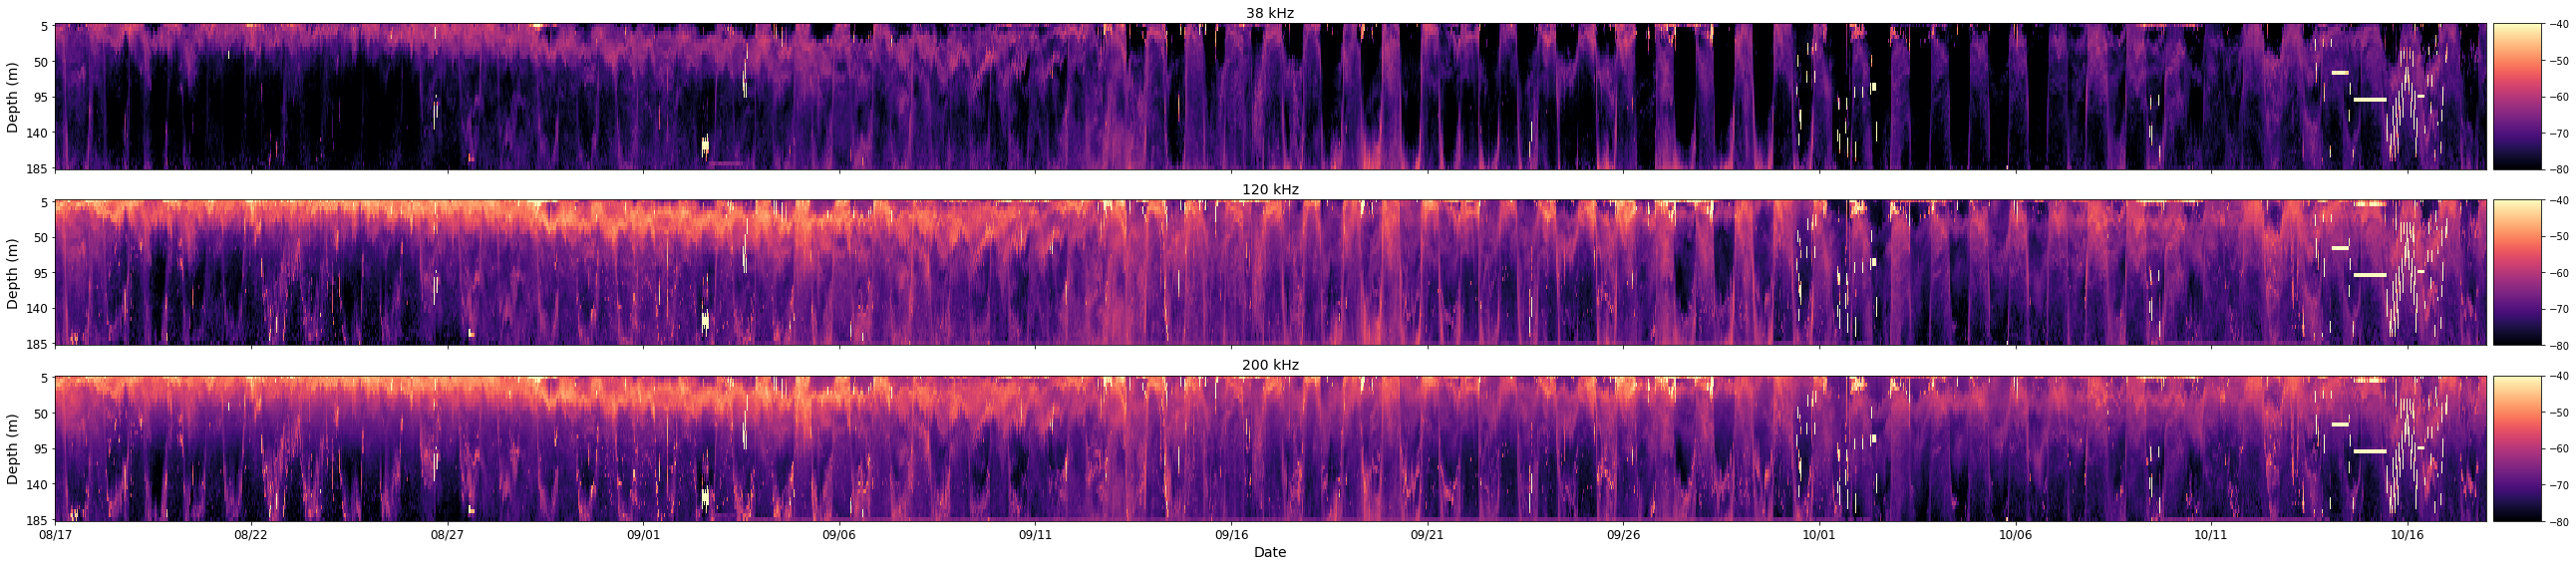

In [10]:
# db_diff.plot_echogram(MVBS,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),'magma')
db_diff.plot_echogram(MVBS,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),db_diff.e_cmap)

## dB-differencing operation

Here I used the criteria from Sato et al. 2015 for dB-differencing. The rationale is that this is the latest publication in nearby region and the classification threshold was selected based on trawl-verified animal groups. The classification rules are:
- Fish:        -16dB < Sv_200-Sv_38 <= 2dB
- Zooplankton:   2dB < Sv_200-Sv_38 <  30dB
- Others:       30dB < Sv_200-Sv_38 or Sv_200-Sv_38 <= -16dB

In [40]:
Sv_1 = MVBS[2,:,:]
Sv_2 = MVBS[0,:,:]

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<=2)) & (Sv_diff_12>-16)
idx_zoop = np.isposinf(Sv_diff_12) | ((Sv_diff_12>2) & (Sv_diff_12<30))
idx_other = (Sv_diff_12<=-16) | (Sv_diff_12>=30)

In [41]:
MVBS_fish = np.ma.empty(MVBS.shape)
for ff in range(MVBS.shape[0]):
    MVBS_fish[ff,:,:] = np.ma.masked_where(~idx_fish,MVBS[ff,:,:])
    
MVBS_zoop = np.ma.empty(MVBS.shape)
for ff in range(MVBS.shape[0]):
    MVBS_zoop[ff,:,:] = np.ma.masked_where(~idx_zoop,MVBS[ff,:,:])
    
MVBS_others = np.ma.empty(MVBS.shape)
for ff in range(MVBS.shape[0]):
    MVBS_others[ff,:,:] = np.ma.masked_where(~idx_other,MVBS[ff,:,:])

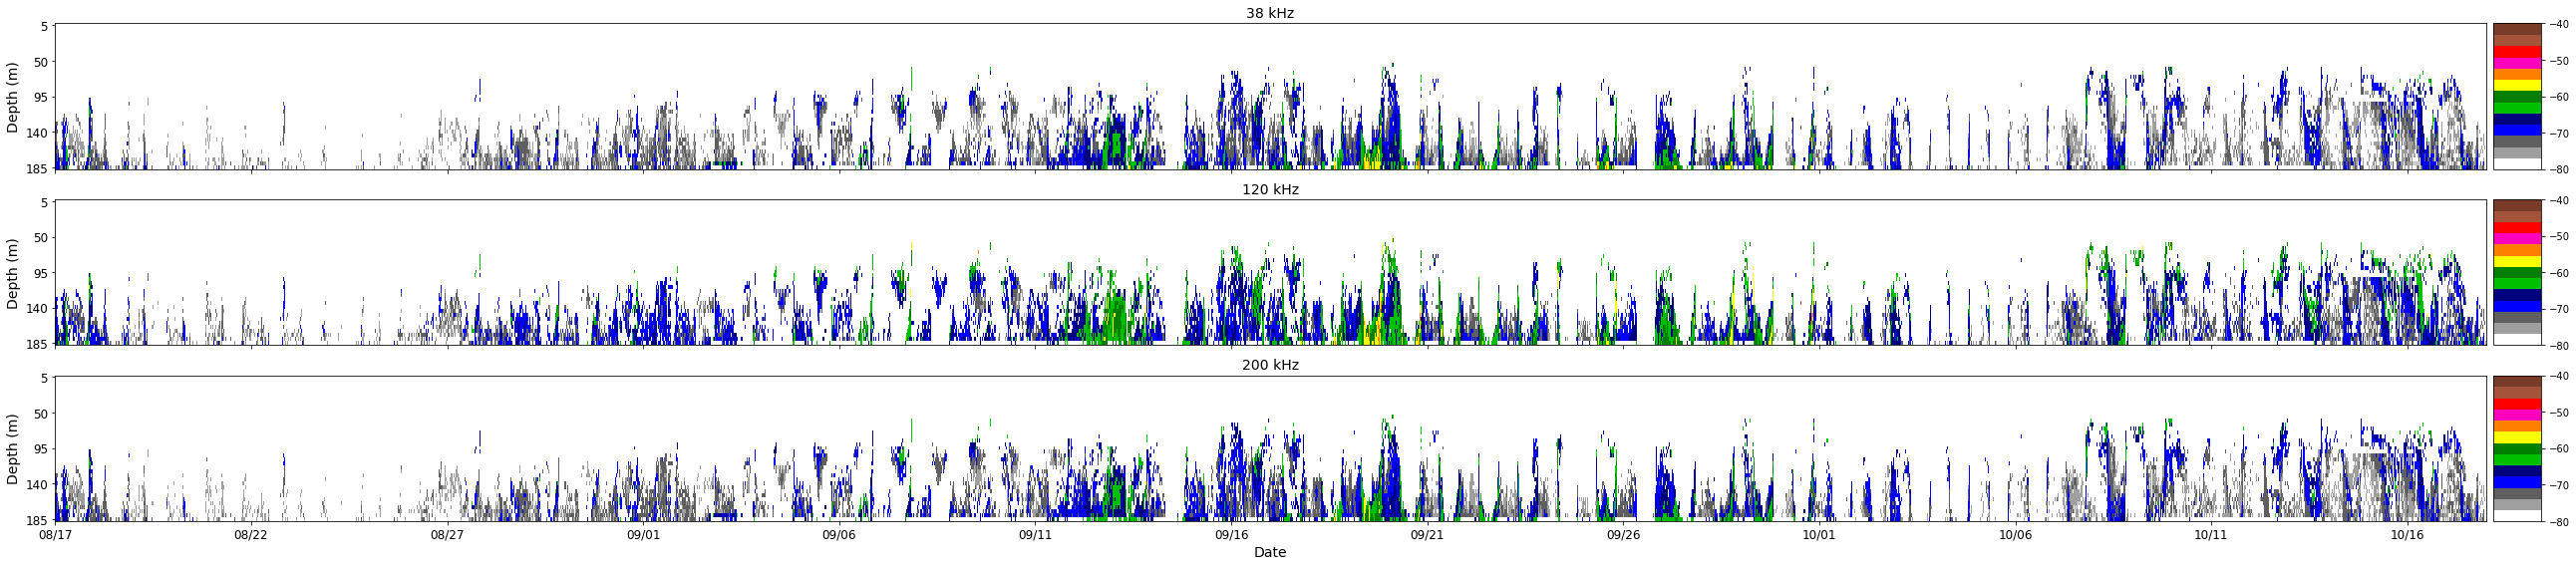

In [45]:
# db_diff.plot_echogram(MVBS_fish,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),'magma')
db_diff.plot_echogram(MVBS_fish,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),db_diff.e_cmap)

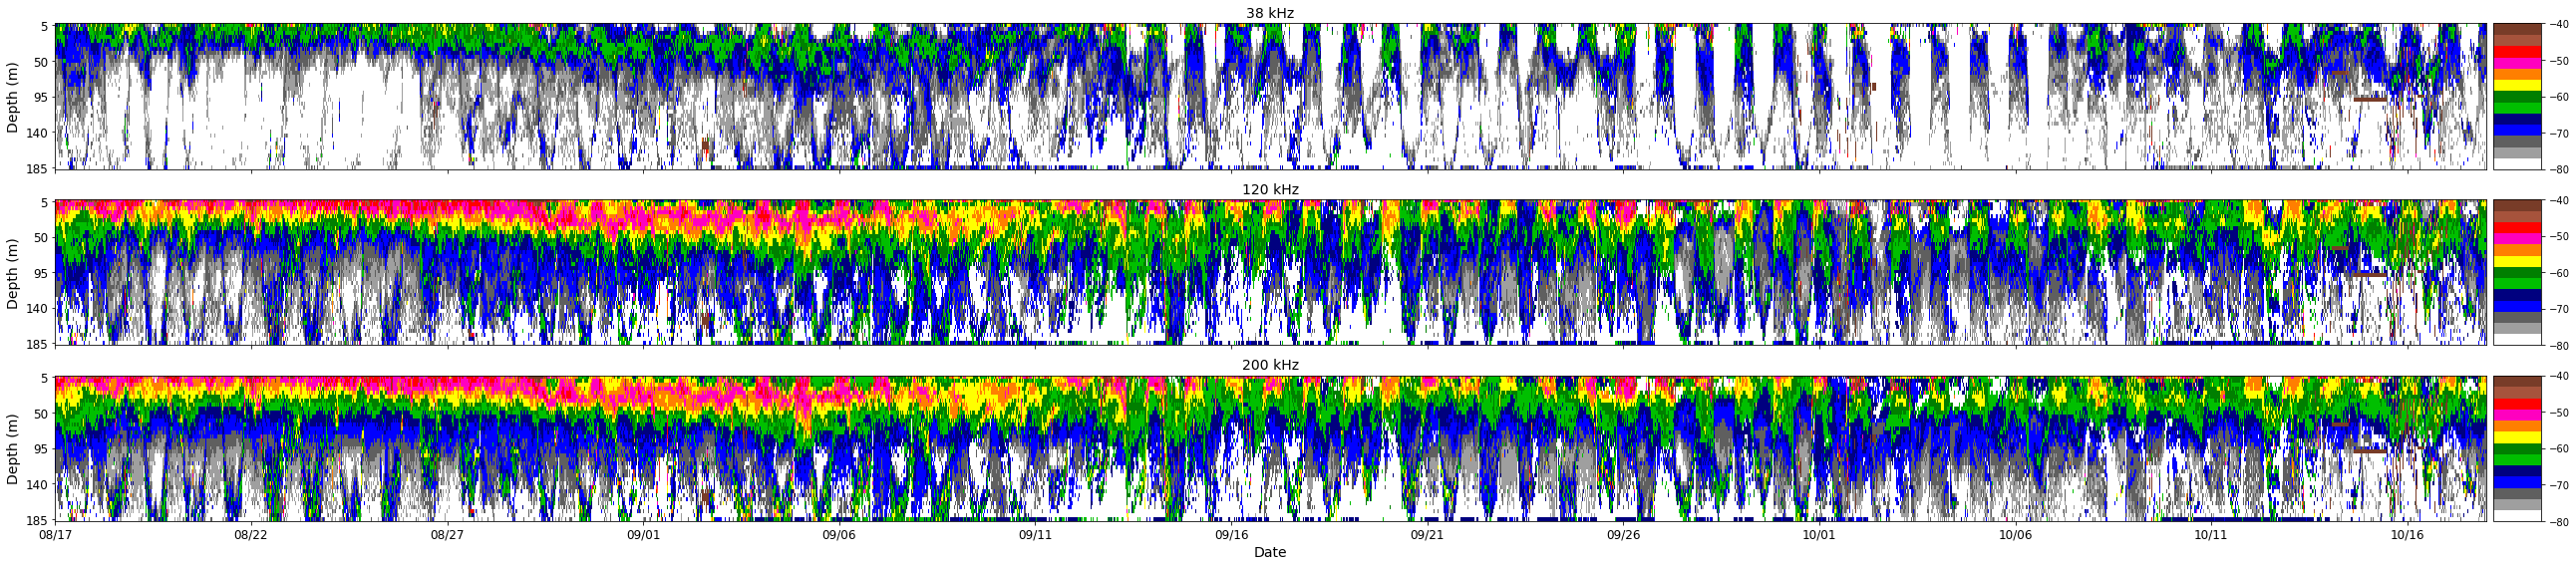

In [46]:
# db_diff.plot_echogram(MVBS_zoop,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),'magma')
db_diff.plot_echogram(MVBS_zoop,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),db_diff.e_cmap)

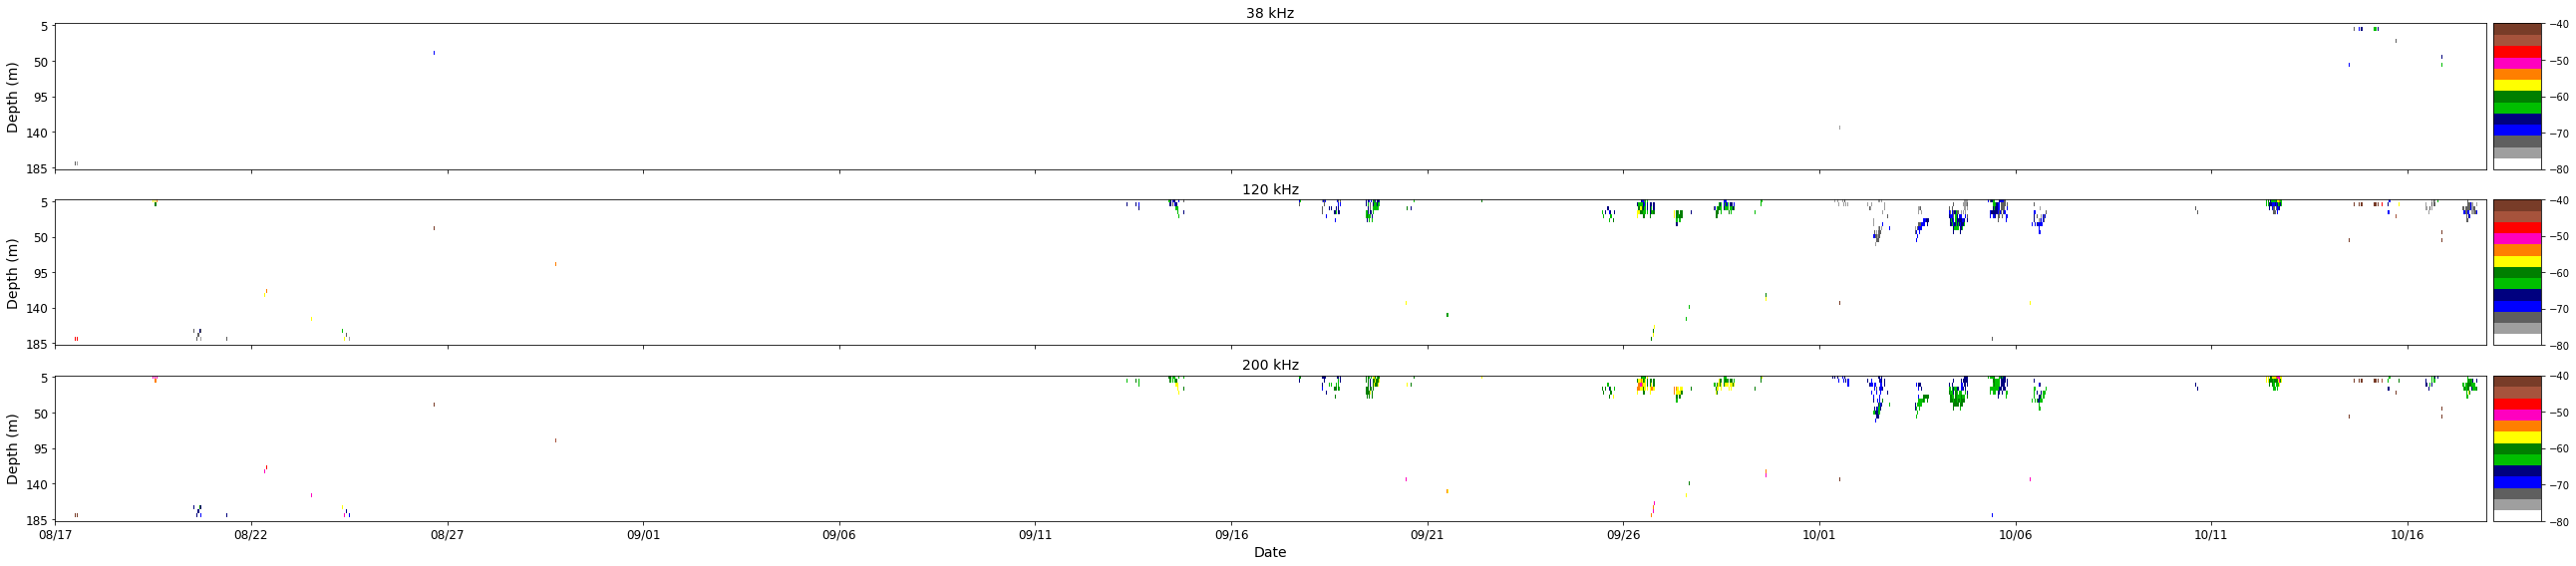

In [47]:
# db_diff.plot_echogram(MVBS_others,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),'magma')
db_diff.plot_echogram(MVBS_others,1,62,5,ping_per_day_mvbs,depth_bin_size,ping_time,(36,8),db_diff.e_cmap)